<a href="https://colab.research.google.com/github/plus2net/Python-basics/blob/main/Mutual_Fund_NAV_Tracking_1_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://www.plus2net.com/images/top2.jpg)        More on  [Mutual fund NAV tracking ](https://www.plus2net.com/python/bs4-automate-mutual-fund-nav-tracking-mfapi.php)

Get the current NAV of a fund by entering the scheme code.

In [1]:
import requests

def get_latest_nav(scheme_code):
    url = f"https://api.mfapi.in/mf/{scheme_code}/latest"
    response = requests.get(url)
    data = response.json()

    latest_nav = data['data'][0]['nav']
    date = data['data'][0]['date']
    fund_name = data['meta']['scheme_name']

    return fund_name, latest_nav, date

# Example: Quant Small Cap Fund (Direct Plan)
name, nav, date = get_latest_nav("120847")
print(f"Fund: {name} | Current NAV: {nav} | Date: {date}")

Fund: quant ELSS Tax Saver Fund - Growth Option - Direct Plan | Current NAV: 396.40210 | Date: 28-01-2026


Tracking multiple funds

In [2]:
import requests
import json
from datetime import datetime

def fetch_latest_navs(scheme_list):
    """
    Retrieves the most recent NAV and corresponding date for a list of funds.
    """
    base_url = "https://api.mfapi.in/mf/"
    final_report = []

    print(f"{'SCHEME NAME':<65} | {'NAV':<10} | {'DATE':<12}")
    print("=" * 92)

    for scheme in scheme_list:
        code = scheme['schemeCode']
        name = scheme['schemeName']

        try:
            # Request data from MFAPI
            response = requests.get(f"{base_url}{code}/latest", timeout=10)
            response.raise_for_status()
            data = response.json()

            if "data" in data and len(data["data"]) > 0:
                # API data is usually in reverse chronological order.
                latest = data["data"][0]
                nav = latest["nav"]
                date = latest["date"]

                final_report.append({
                    "name": name,
                    "code": code,
                    "nav": nav,
                    "date": date
                })

                # Truncated name for table alignment
                short_name = (name[:62] + '..') if len(name) > 65 else name
                print(f"{short_name:<65} | {nav:<10} | {date:<12}")
            else:
                print(f"Data missing for: {name}")

        except Exception as e:
            print(f"Could not retrieve {code}: {e}")

    return final_report

if __name__ == "__main__":
    # Input scheme list
    input_schemes = [
        {"schemeCode": 120251, "schemeName": "ICICI Prudential Equity & Debt Fund Direct Growth"},
        {"schemeCode": 118955, "schemeName": "HDFC Flexi Cap Direct Plan Growth"},
        {"schemeCode": 120334, "schemeName": "ICICI Prudential Multi Asset Fund Direct Growth"}
    ]

    print(f"Querying MFAPI for latest records...\n")
    results = fetch_latest_navs(input_schemes)

Querying MFAPI for latest records...

SCHEME NAME                                                       | NAV        | DATE        
ICICI Prudential Equity & Debt Fund Direct Growth                 | 448.35000  | 28-01-2026  
HDFC Flexi Cap Direct Plan Growth                                 | 2243.14100 | 28-01-2026  
ICICI Prudential Multi Asset Fund Direct Growth                   | 897.45180  | 27-01-2026  


Plotting graphs based on NAV of a fund

--- Mutual Fund NAV Tracker ---
Enter the Mutual Fund Scheme Code: 120251
Fetching data for Scheme Code: 120251...
Displaying graph...


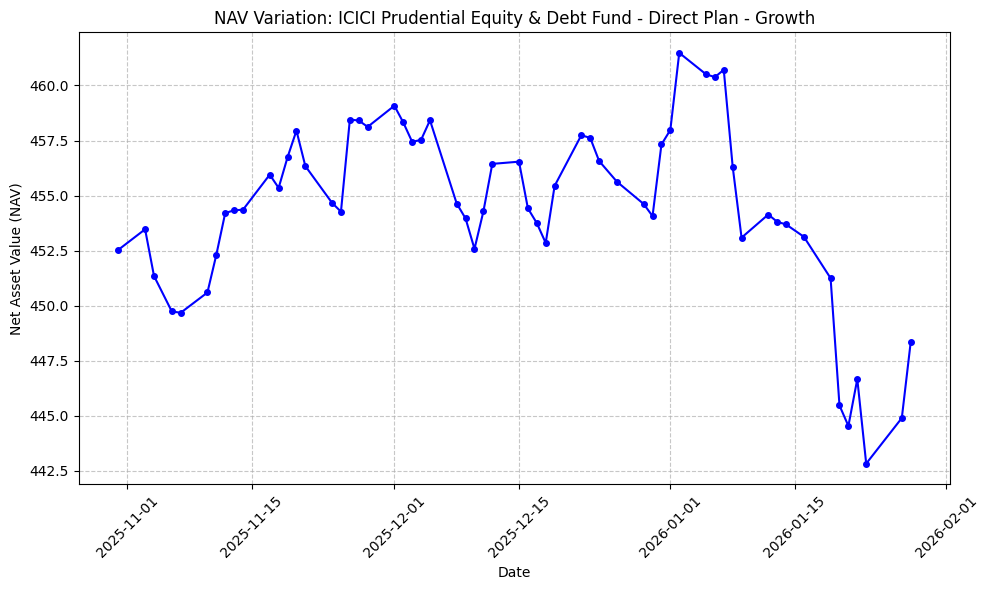

In [3]:
import requests
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_and_plot_nav(scheme_code):
    """
    Fetches historical NAV data for a given scheme code from mfapi.in
    and plots the variation over time.
    """
    api_url = f"https://api.mfapi.in/mf/{scheme_code}"

    print(f"Fetching data for Scheme Code: {scheme_code}...")

    try:
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        data = response.json()

        if data.get("status") != "SUCCESS":
            print("Error: Could not find data for this scheme code.")
            return

        scheme_name = data['meta']['scheme_name']
        nav_data = data['data']

        # Extract dates and NAV values
        # We take the last 60 entries for a clear 2-month view
        subset = nav_data[:60]

        # Parse dates and convert NAVs to floats
        dates = [datetime.strptime(item['date'], '%d-%m-%Y') for item in subset]
        nav_values = [float(item['nav']) for item in subset]

        # Sort by date
        plot_data = sorted(zip(dates, nav_values))
        dates, nav_values = zip(*plot_data)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(dates, nav_values, marker='o', linestyle='-',
		color='b', markersize=4)

        plt.title(f"NAV Variation: {scheme_name}", fontsize=12)
        plt.xlabel("Date")
        plt.ylabel("Net Asset Value (NAV)")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()

        print("Displaying graph...")
        plt.show()

    except requests.exceptions.RequestException as e:
        print(f"Network error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    print("--- Mutual Fund NAV Tracker ---")
    user_code = input("Enter the Mutual Fund Scheme Code: ").strip()

    if user_code.isdigit():
        fetch_and_plot_nav(user_code)
    else:
        print("Please enter a valid numeric scheme code.")

Automating Mutual Fund Portfolio Tracking

In [4]:
import requests
import json
import time
from datetime import datetime

def fetch_nav_with_retry(scheme_code):
    """
    Fetches the latest NAV for a given scheme code from the AMFI API.
    Implements exponential backoff for reliability.
    """
    api_url = f"https://api.mfapi.in/mf/{scheme_code}"
    retries = 5
    delay = 1

    for i in range(retries):
        try:
            response = requests.get(api_url, timeout=10)
            response.raise_for_status()
            data = response.json()

            # The API returns a list of NAVs, we take the most recent one (index 0)
            if "data" in data and len(data["data"]) > 0:
                latest_nav_data = data["data"][0]
                return {
                    "nav": float(latest_nav_data["nav"]),
                    "date": latest_nav_data["date"]
                }
            return None
        except (requests.RequestException, ValueError, KeyError):
            if i < retries - 1:
                time.sleep(delay)
                delay *= 2  # Exponential backoff: 1s, 2s, 4s, 8s, 16s
            else:
                return None

def calculate_portfolio():
    # User Input Data , expand this list based
    input_schemes = [
        {"schemeCode": 120251,
         "schemeName": "ICICI Prudential Equity & Debt Fund Direct Growth",
           "Units": 100.02},

        {"schemeCode": 118955,
         "schemeName": "HDFC Flexi Cap Direct Plan Growth",
           "Units": 250.589},

        {"schemeCode": 120334,
         "schemeName": "ICICI Prudential Multi Asset Fund Direct Growth",
           "Units": 200.567}
    ]

    results = []
    total_portfolio_value = 0.0

    print("Fetching real-time data from AMFI...")

    for scheme in input_schemes:
        nav_info = fetch_nav_with_retry(scheme["schemeCode"])

        if nav_info:
            current_value = nav_info["nav"] * scheme["Units"]
            total_portfolio_value += current_value

            results.append({
                "Date": nav_info["date"],
                "Fund Name": scheme["schemeName"],
                "NAV": nav_info["nav"],
                "Units": scheme["Units"],
                "Investment": round(current_value, 2)
            })
        else:
            print(f"Error: Could not fetch data for {scheme['schemeName']}")

    # --- OUTPUT ---
    print("\n" + "="*80)
    print(f" TOTAL INVESTMENT VALUE: ₹{total_portfolio_value:,.2f}")
    print("="*80)

    # Header
    print(f"{'Date':<12} | {'Fund Name':<50} | {'NAV':<8} | {'Units':<10} | {'Investment':<12}")
    print("-" * 105)

    # Rows
    for r in results:
        print(f"{r['Date']:<12} | {r['Fund Name'][:50]:<50} | {r['NAV']:<8.2f} | {r['Units']:<10.3f} | ₹{r['Investment']:<12,.2f}")

if __name__ == "__main__":
    calculate_portfolio()

Fetching real-time data from AMFI...

 TOTAL INVESTMENT VALUE: ₹786,949.64
Date         | Fund Name                                          | NAV      | Units      | Investment  
---------------------------------------------------------------------------------------------------------
28-01-2026   | ICICI Prudential Equity & Debt Fund Direct Growth  | 448.35   | 100.020    | ₹44,843.97   
28-01-2026   | HDFC Flexi Cap Direct Plan Growth                  | 2243.14  | 250.589    | ₹562,106.46  
27-01-2026   | ICICI Prudential Multi Asset Fund Direct Growth    | 897.45   | 200.567    | ₹179,999.22  


Using excel file to store investment details.

Download sample excel file or use your own excel file. If can upload your excel file to left side panel and use here.

In [5]:
!wget https://www.plus2net.com/python/download/input_schemes.xlsx # download sample excel file.

--2026-01-29 05:50:42--  https://www.plus2net.com/python/download/input_schemes.xlsx
Resolving www.plus2net.com (www.plus2net.com)... 184.168.96.1
Connecting to www.plus2net.com (www.plus2net.com)|184.168.96.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9196 (9.0K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘input_schemes.xlsx’

input_schemes.xlsx  100%[===================>]   8.98K  --.-KB/s    in 0s      

2026-01-29 05:50:42 (129 MB/s) - ‘input_schemes.xlsx’ saved [9196/9196]



Use the above excel file as source and then create the total investment value.

In [6]:
import requests
import json
import time
import pandas as pd
from datetime import datetime

def fetch_nav_with_retry(scheme_code):
    """
    Fetches the latest NAV for a given scheme code from the AMFI API.
    Implements exponential backoff for reliability.
    """
    api_url = f"https://api.mfapi.in/mf/{scheme_code}"
    retries = 5
    delay = 1

    for i in range(retries):
        try:
            response = requests.get(api_url, timeout=10)
            response.raise_for_status()
            data = response.json()

            # The API returns a list of NAVs, we take the most recent one (index 0)
            if "data" in data and len(data["data"]) > 0:
                latest_nav_data = data["data"][0]
                return {
                    "nav": float(latest_nav_data["nav"]),
                    "date": latest_nav_data["date"]
                }
            return None
        except (requests.RequestException, ValueError, KeyError):
            if i < retries - 1:
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            else:
                return None

def calculate_portfolio():
    # --- LOAD DATA FROM FILE ---
    try:
        # Update filename here if needed. Using pd.read_csv for your uploaded file.
        #df = pd.read_csv('input_schemes.xlsx - Sheet1.csv')
        #df = pd.read_excel('E:\\testing3\\input_schemes.xlsx', sheet_name='Sheet1')
        df = pd.read_excel('input_schemes.xlsx', sheet_name='Sheet1')
        # Convert dataframe to a list of dictionaries to maintain the loop logic
        input_schemes = df.to_dict('records')
    except Exception as e:
        print(f"Error reading the file: {e}")
        return

    results = []
    total_portfolio_value = 0.0

    print(f"Fetching real-time data for {len(input_schemes)} funds from AMFI...")

    for scheme in input_schemes:
        # Note: Ensure keys match the column names in your CSV exactly
        nav_info = fetch_nav_with_retry(scheme["schemeCode"])

        if nav_info:
            current_value = nav_info["nav"] * scheme["Units"]
            total_portfolio_value += current_value

            results.append({
                "Date": nav_info["date"],
                "Fund Name": scheme["schemeName"],
                "NAV": nav_info["nav"],
                "Units": scheme["Units"],
                "Investment": round(current_value, 2)
            })
        else:
            print(f"Error: Could not fetch data for {scheme['schemeName']}")

    # --- OUTPUT ---
    print("\n" + "="*85)
    print(f" TOTAL PORTFOLIO VALUE: ₹{total_portfolio_value:,.2f}")
    print("="*85)

    # Header
    print(f"{'Date':<12} | {'Fund Name':<40} | {'NAV':<8} | {'Units':<10} | {'Value (₹)':<12}")
    print("-" * 95)

    # Rows
    for r in results:
        print(f"{r['Date']:<12} | {r['Fund Name'][:40]:<40} | {r['NAV']:<8.2f} | {r['Units']:<10.3f} | ₹{r['Investment']:<12,.2f}")

if __name__ == "__main__":
    calculate_portfolio()

Fetching real-time data for 3 funds from AMFI...

 TOTAL PORTFOLIO VALUE: ₹786,949.64
Date         | Fund Name                                | NAV      | Units      | Value (₹)   
-----------------------------------------------------------------------------------------------
28-01-2026   | ICICI Prudential Equity & Debt Fund Dire | 448.35   | 100.020    | ₹44,843.97   
28-01-2026   | HDFC Flexi Cap Direct Plan Growth        | 2243.14  | 250.589    | ₹562,106.46  
27-01-2026   | ICICI Prudential Multi Asset Fund Direct | 897.45   | 200.567    | ₹179,999.22  
